In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
train = pd.read_csv("data/train_manual_features.csv", index_col=0)
test = pd.read_csv("data/test_manual_features.csv", index_col=0)

In [3]:
train['comment_text'] = train['comment_text'].astype(str)
test['comment_text'] = test['comment_text'].astype(str)

In [4]:
def log_col(df, cols):
    for col in cols:
        print(col)
        df['log_'+col] = np.log(df[col]+0.1)
        scaler = StandardScaler()
        df['log_'+col] = scaler.fit_transform(df['log_'+col].values.reshape(-1, 1))
        df['log_'+col].hist()
        plt.show()
    return df

In [5]:
manual_features = ['comment_length', 'num_?', 'num_!', 'num_*', 'num_upper', 'num_you']

comment_length


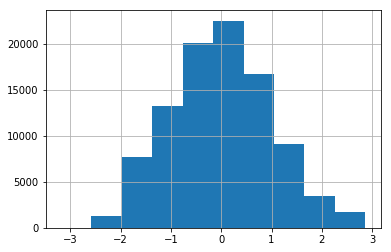

num_?


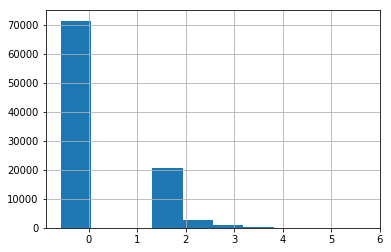

num_!


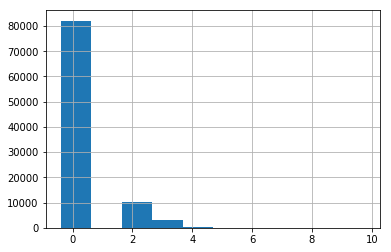

num_*


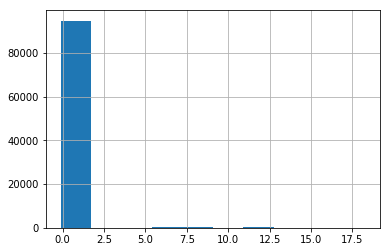

num_upper


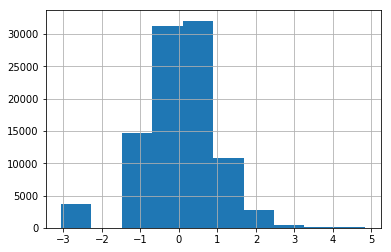

num_you


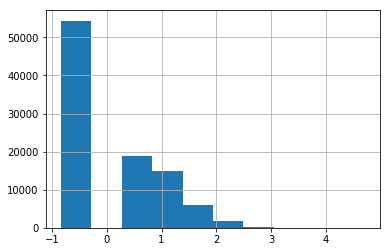

comment_length


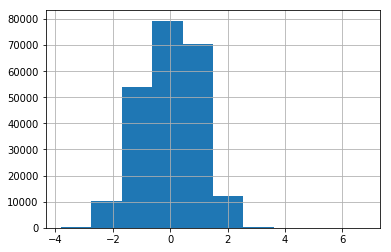

num_?


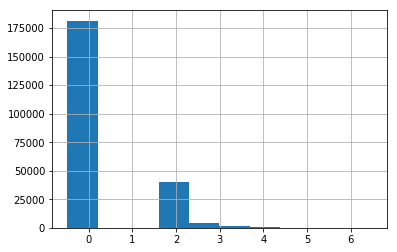

num_!


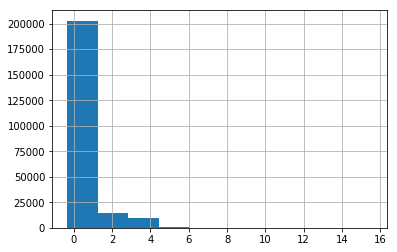

num_*


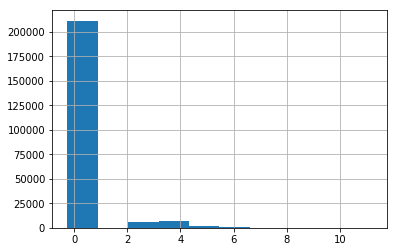

num_upper


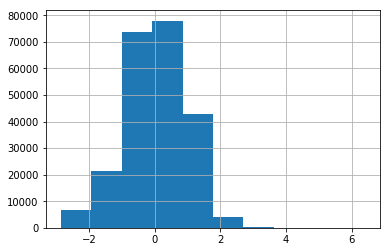

num_you


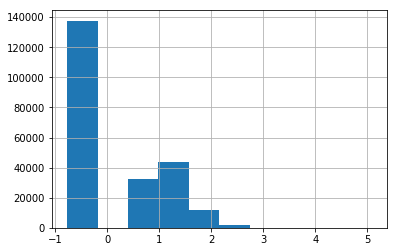

In [6]:
train = log_col(train, manual_features)
test = log_col(test, manual_features)

In [7]:
def sample1():
    train_pos = train[train["toxic"] == 1]
    train_neg = train[train["toxic"] == 0]

    print(train_pos.shape)
    print(train_neg.shape)

    train_set = train_pos.sample(frac=0.8)
    train_set = train_set.append(train_neg.sample(n=train_set.shape[0]))

    val_set = train.drop(train_set.index)

    train_set.reset_index(drop=True)
    val_set.reset_index(drop=True)

    print(train_set['toxic'].describe())
    print(val_set['toxic'].describe())
    
    return train_set, val_set, {0: 1, 1:1}

In [8]:
def sample2():
    train_set = train.sample(frac=0.8)
    val_set = train.drop(train_set.index)
    
    class_weight = {0: len(train) / 2 / (len(train) - sum(train['toxic'])), 1: len(train) / 2 / sum(train['toxic']) }
    
    train_set = train_set.reset_index(drop=True)
    val_set = val_set.reset_index(drop=True)
    
    print(train_set['toxic'].describe())
    print(val_set['toxic'].describe())
    
    return train_set, val_set, class_weight

In [9]:
train_set, val_set, class_weight = sample2()

count    76681.000000
mean         0.096960
std          0.295905
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: toxic, dtype: float64
count    19170.000000
mean         0.094001
std          0.291838
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: toxic, dtype: float64


In [10]:
from keras.preprocessing import text, sequence

max_features = 20000
maxlen = 128

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_set['comment_text'])

Using TensorFlow backend.


In [11]:
r_word_index = { v:k for k, v in tokenizer.word_index.items()}

In [12]:
X_tr = sequence.pad_sequences(tokenizer.texts_to_sequences(train_set['comment_text']), maxlen=maxlen)
X_va = sequence.pad_sequences(tokenizer.texts_to_sequences(val_set['comment_text']), maxlen=maxlen)
X_te = sequence.pad_sequences(tokenizer.texts_to_sequences(test['comment_text']), maxlen=maxlen)

y_tr = train_set['toxic']
y_va = val_set['toxic']

In [13]:
EMBEDDING_DIM = 300


from tqdm import tqdm

embeddings_index = {}
f = open("data/glove.6B.300d.txt".format(EMBEDDING_DIM))
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:29, 13450.21it/s]


Found 400000 word vectors.


In [14]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [15]:
embedding_matrix.shape

(133570, 300)

In [16]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Flatten
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, GRU, Conv1D, Reshape, MaxPooling1D, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.constraints import non_neg, unit_norm

CONV_SIZE = EMBEDDING_DIM
LSTM_SIZE = 128

other = ["severe_toxic", "obscene", "threat", "insult", "identity_hate"]

def encoder(inp):
    
    """
    glove = Embedding(max_features, EMBEDDING_DIM)(inp)
    enc = GlobalMaxPool1D()(glove)
    """
    glove = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)(inp)
    enc = Bidirectional(GRU(LSTM_SIZE))(glove)
    
    """
    enc = Conv1D(CONV_SIZE * 2, 2, strides=1, padding='valid', activation='relu')(glove)
    enc = MaxPooling1D(4)(enc)
    enc = Conv1D(CONV_SIZE * 4, 2, strides=1, padding='valid', activation='relu')(enc)
    enc = GlobalMaxPool1D()(enc)
    
    enc = Flatten()(enc)
    """
    return enc


def get_model_orig():
    embed_size = 32
    inp = Input(shape=(maxlen, ))
    other_inp = Input(shape=(len(other), ))
    feat_inp = Input(shape=(len(manual_features), ))
    
    """

    x = Embedding(max_features, embed_size)(inp)
    """
    enc = encoder(inp)

    """
    g = Bidirectional(GRU(LSTM_SIZE, return_sequences=True))(g)
    g = Bidirectional(GRU(LSTM_SIZE))(g)

    g = Conv1D(CONV_SIZE, 2, strides=1, padding='valid', activation='selu')(g)
    g = MaxPooling1D(2)(g)
    g = Conv1D(CONV_SIZE, 2, strides=1, padding='valid', activation='selu')(g)
    g = MaxPooling1D(2)(g)
    g = Conv1D(CONV_SIZE, 2, strides=1, padding='valid', activation='selu')(g)
    g = MaxPooling1D(2)(g)
    g = Conv1D(CONV_SIZE, 2, strides=1, padding='valid', activation='selu')(g)
    g = MaxPooling1D(2)(g)    
    glove_emb_max = GlobalMaxPool1D()(g)
    """
    
    #x = GlobalMaxPool1D()(x)
    others = Dense(10, activation="selu")(other_inp)
    
    x = Concatenate()([others, enc, feat_inp])
    
    x = Dropout(0.2)(x)
    
    
    pred = Dense(1, activation="sigmoid"
                 #bias_constraint=non_neg(), 
                 #kernel_constraint=non_neg()
                )(x)
    model = Model(inputs=[inp, other_inp, feat_inp], outputs=pred)
    
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', 'binary_crossentropy'])

    return model


def get_model():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, EMB_SIZE, embeddings_regularizer=l2(1e-3))(inp)
    #x = Reshape((maxlen, embed_size, 1))(x)
    #x = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True))(x)
    x = Conv1D(CONV_SIZE, 2, strides=1, padding='valid', activation='selu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(CONV_SIZE, 2, strides=1, padding='valid', activation='selu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(CONV_SIZE, 2, strides=1, padding='valid', activation='selu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(CONV_SIZE, 2, strides=1, padding='valid', activation='selu')(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(LSTM_SIZE))(x)
    #x = Dense(LSTM_SIZE, activation="selu")(x)
    x = Dense(len(list_classes), activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', 'binary_crossentropy'])

    return model

model = get_model_orig()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 300)     40071000    input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           60          input_2[0][0]                    
__________________________________________________________________________________________________
bidirectio

In [17]:
batch_size = 128
epochs = 20000

file_path="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', save_best_only=True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks_list = [checkpoint, early] #early
model.fit([X_tr, train_set[other], train_set[manual_features]], y_tr, class_weight=None, validation_data=([X_va, val_set[other], val_set[manual_features]], y_va), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks_list)

Train on 76681 samples, validate on 19170 samples
Epoch 1/20000
76681/76681 [==============================] - 165s 2ms/step - loss: 0.1462 - acc: 0.9513 - binary_crossentropy: 0.1462 - val_loss: 0.1048 - val_acc: 0.9612 - val_binary_crossentropy: 0.1048
Epoch 2/20000
76681/76681 [==============================] - 163s 2ms/step - loss: 0.1029 - acc: 0.9642 - binary_crossentropy: 0.1029 - val_loss: 0.1048 - val_acc: 0.9624 - val_binary_crossentropy: 0.1048
Epoch 3/20000
76681/76681 [==============================] - 163s 2ms/step - loss: 0.0927 - acc: 0.9668 - binary_crossentropy: 0.0927 - val_loss: 0.0988 - val_acc: 0.9645 - val_binary_crossentropy: 0.0988
Epoch 4/20000
76681/76681 [==============================] - 161s 2ms/step - loss: 0.0830 - acc: 0.9705 - binary_crossentropy: 0.0830 - val_loss: 0.1065 - val_acc: 0.9643 - val_binary_crossentropy: 0.1065
Epoch 5/20000
13952/76681 [====>.........................] - ETA: 1:57 - loss: 0.0654 - acc: 0.9758 - binary_crossentropy: 0.0654

KeyboardInterrupt: 

In [ ]:
model.load_weights(file_path)


pred = model.predict([X_va, val_set[other]])
val_set['pred_toxic'] = pred

In [ ]:
from sklearn import metrics

pred = val_set['pred_toxic'].apply(lambda x: 1 if x>=0.5 else 0)

print("roc:\t\t%.3f" % metrics.roc_auc_score(val_set['toxic'], val_set['pred_toxic']))
print("f1:\t\t%.3f" % metrics.f1_score(val_set['toxic'], pred))
print("precision:\t%.3f" % metrics.precision_score(val_set['toxic'], pred))
print("recall:\t\t%.3f" %metrics.recall_score(val_set['toxic'], pred))
precision, recall, threshold = metrics.precision_recall_curve(val_set['toxic'], val_set['pred_toxic'])
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve:')
plt.show()

In [ ]:
for i, row in val_set[(val_set['pred_toxic'] >= 0.9) & (val_set['toxic'] == 0)].sample(1).iterrows():
    print(row['comment_text'])
    print(row)

In [ ]:
y_va != pred_va

In [ ]:
sample_submission = pd.read_csv("./data/sample_submission.csv")

sample_submission[list_classes] = y_test



sample_submission.to_csv("baseline.csv", index=False)